# Similarity Modeling 1/2: Recognizing Waldorf & Statler

## Student
Gallus Huber (51905700)

## Timesheet
2022-12-28 18:00 - 21:30 Setup <br />
2022-12-29 09:00 - 12:00 Exploration

## Required libraries and installs

In [1]:
!cat requirements-fe-audio.txt
!pip install -r requirements-fe-audio.txt

pandas
numpy
opencv-python
matplotlib
librosaLooking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
#!brew install ffmpeg # MacOS (tested)
#!sudo apt install ffmpeg # Ubuntu (not tested)

## Imports

In [3]:
import os
import glob
import pathlib

import pandas as pd
import numpy as np

import cv2 as cv2
import matplotlib.pyplot as plt

import librosa
import librosa.display

## Constants

In [4]:
# path to ground truth and videos
DATA_PATH = "/content/drive/MyDrive/data/"
GROUND_TRUTH_PATH = os.path.join(DATA_PATH, "sim12-ground-truth-muppets")
VIDEO_PATH = os.path.join(DATA_PATH, "video")
AUDIO_PATH = os.path.join(DATA_PATH, "audio")

# Project Structure

In [5]:
if not os.path.exists(AUDIO_PATH):
    os.makedirs(AUDIO_PATH)

# 1. Data Preparation

## 1.1 List all videos

In [6]:
videos = glob.glob(VIDEO_PATH + '/*.avi')

videos_tmp = []
for video in videos:
    videos_tmp.append(pathlib.Path(video).name)
videos = videos_tmp

videos

['Muppets-03-04-03.avi', 'Muppets-02-01-01.avi', 'Muppets-02-04-04.avi']

## 1.2 Read ground truth from CSV

In [7]:
ground_truth = dict()

# read in corresponding ground truth
for video in videos:
        file_name = glob.glob(GROUND_TRUTH_PATH + '/*' + os.path.splitext(video)[0] + '*.csv')
        csv = pd.read_csv(os.path.join(file_name[0]), sep=";")
        ground_truth[video] = csv

## 1.3 Plot the ground truth

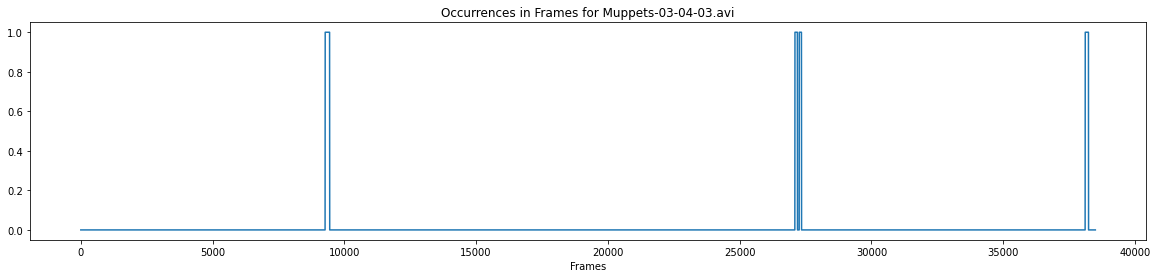

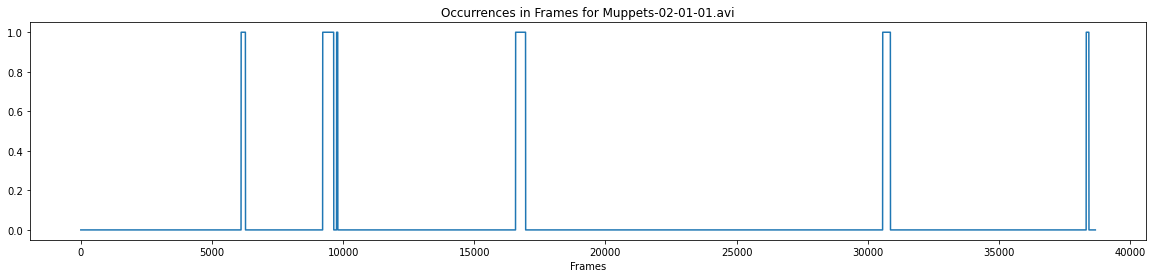

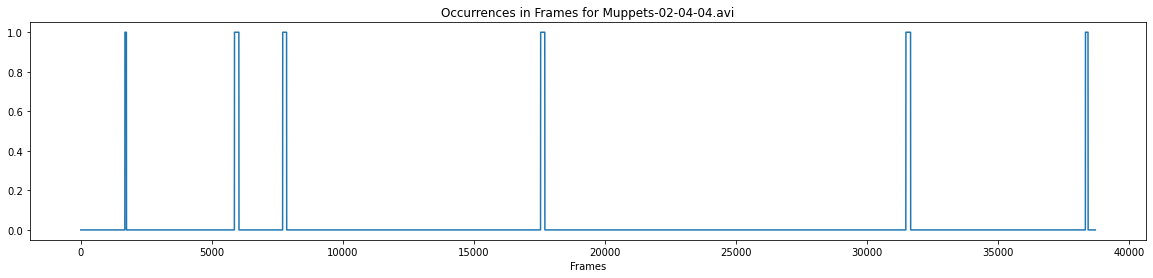

In [8]:
for video in videos:
    plot = plt.figure(figsize=(20, 4))

    # define subplot
    subplot = plot.add_subplot(111)
    subplot.set_title(f"Occurrences in Frames for {video}")

    # define x axis
    subplot.set_xlabel('Frames')

    # mark occurrences
    frame_indicator = np.zeros(len(ground_truth[video]['Frame_number']))
    frame_indicator[ground_truth[video][ground_truth[video]["Audio_StatlerWaldorf"] == 1].index] = 1

    subplot.plot(ground_truth[video]["Audio_StatlerWaldorf"].index, frame_indicator)
    plt.show()

## 1.4 Load video data

In [9]:
video_data = dict()

for video in videos:
        file_name = glob.glob(VIDEO_PATH + '/*' + os.path.splitext(video)[0] + '*.avi')
        video_cap = cv2.VideoCapture(os.path.join(file_name[0]))
        video_data[video] = video_cap

## 1.5 FPS Constant

In [10]:
FPS = 25

## 1.6 Combine data frames, filter for Waldorf & Statler and add seconds

In [11]:
df_gt = pd.concat(ground_truth)

df_gt["Seconds"] = df_gt["Frame_number"] / FPS
df_gt = df_gt[["Video", "Frame_number", "Seconds", "Audio_StatlerWaldorf"]]
df_gt.head()

Video  Frame_number  Seconds  Audio_StatlerWaldorf
Muppets-03-04-03.avi 0    343             0     0.00                     0
                     1    343             1     0.04                     0
                     2    343             2     0.08                     0
                     3    343             3     0.12                     0
                     4    343             4     0.16                     0

## 1.7 Mapping Filename - Video

In [12]:
video2filename = {"Muppets-02-01-01.avi" : 211, "Muppets-02-04-04.avi" : 244,"Muppets-03-04-03.avi" : 343}

## 1.8 Convert .avi to .wav

In [13]:
for video in videos:
        file_name_video = glob.glob(VIDEO_PATH + '/*' + os.path.splitext(video)[0] + '*.avi')[0]
        file_name_audio = os.path.join(AUDIO_PATH, os.path.splitext(video)[0] + '.wav')
        command2wav = f"ffmpeg -i {file_name_video} {file_name_audio}"

        os.system(command2wav)

        # save audio filename to data frame
        df_gt.loc[df_gt["Video"] == video2filename[os.path.splitext(video)[0] + ".avi"], "file_name_audio"] = os.path.splitext(video)[0] + ".wav"

df_gt.head()

Video  Frame_number  Seconds  Audio_StatlerWaldorf  \
Muppets-03-04-03.avi 0    343             0     0.00                     0   
                     1    343             1     0.04                     0   
                     2    343             2     0.08                     0   
                     3    343             3     0.12                     0   
                     4    343             4     0.16                     0   

                             file_name_audio  
Muppets-03-04-03.avi 0  Muppets-03-04-03.wav  
                     1  Muppets-03-04-03.wav  
                     2  Muppets-03-04-03.wav  
                     3  Muppets-03-04-03.wav  
                     4  Muppets-03-04-03.wav

## 1.8 Explore data

### 1.8.1 Constants

In [14]:
SAMPLE_RATE = 16000         # we will use a sample rate of 16kHz
N_FFT = 320                 # = 20ms @ 16kHz
HOP_LENGTH = 160            # = 10ms @ 16kHz
N_MELS = 64

### 1.8.2 Load Signals

In [15]:
signals = dict()
sample_rates = dict()
for file_name in df_gt["file_name_audio"].unique():
    signals[file_name], sample_rates[file_name] = librosa.load(os.path.join(AUDIO_PATH, file_name), sr=SAMPLE_RATE)

### 1.8.3 Waveplot

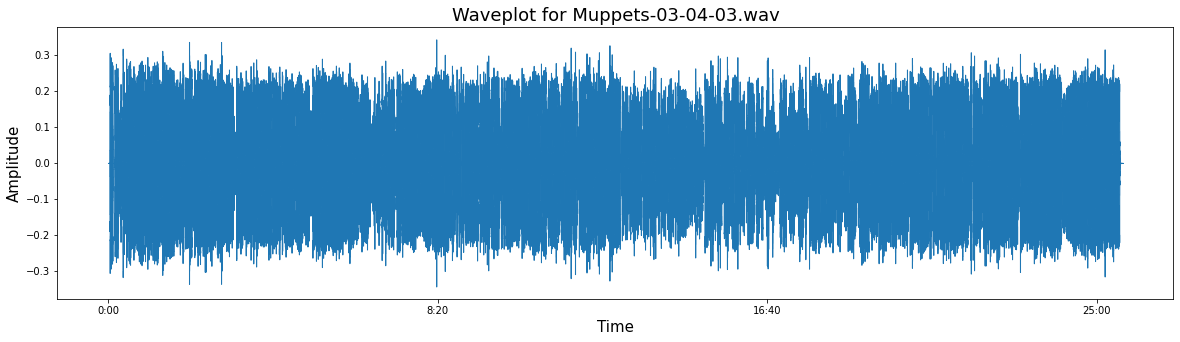

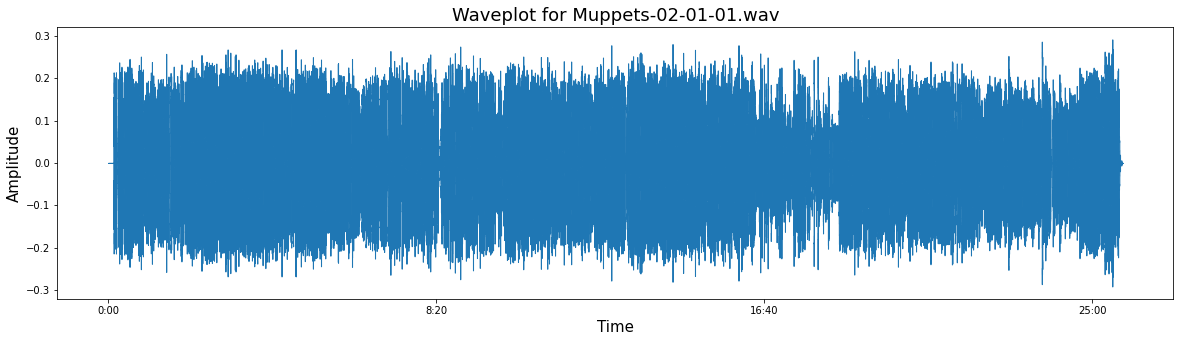

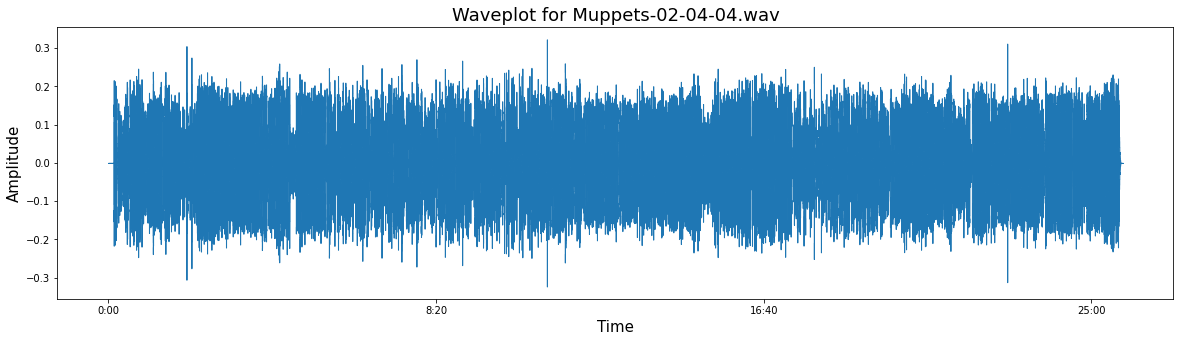

In [16]:
for file_name in df_gt["file_name_audio"].unique():
    plt.figure(figsize=(20, 5))
    plt.title(f"Waveplot for {file_name}", fontdict=dict(size=18))
    plt.xlabel("Time", fontdict=dict(size=15))
    plt.ylabel("Amplitude", fontdict=dict(size=15))

    librosa.display.waveshow(signals[file_name], sr=sample_rates[file_name])
    plt.show()

### 1.8.4 RMS

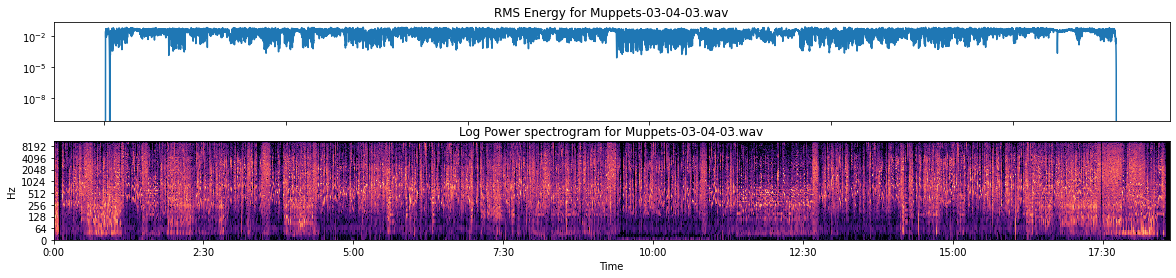

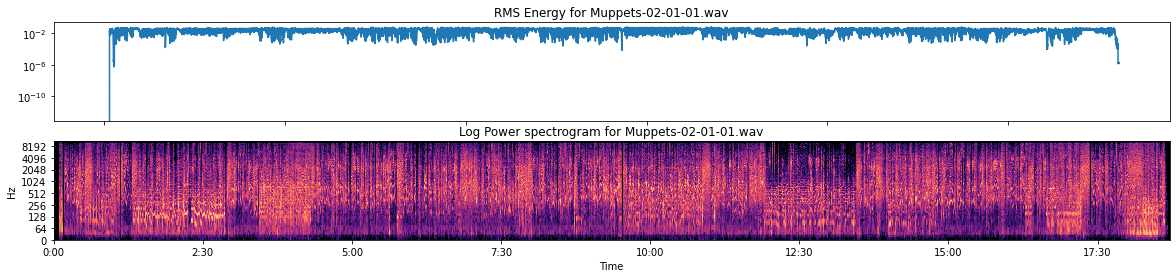

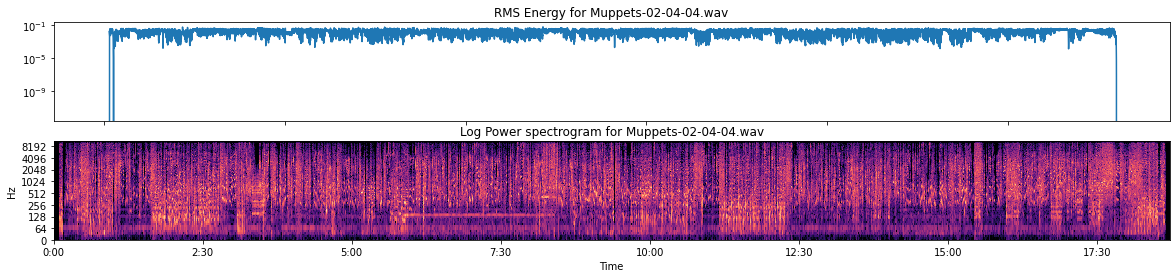

In [17]:
for file_name in df_gt["file_name_audio"].unique():
    stft = librosa.stft(signals[file_name])
    S, phase = librosa.magphase(stft)
    rms = librosa.feature.rms(S=S)
    times_like = librosa.times_like(rms)
    amplitude_to_db = librosa.amplitude_to_db(S, ref=np.max)

    figure, axis = plt.subplots(figsize=(20, 4), nrows=2)

    axis[0].semilogy(times_like, rms[0])
    axis[0].set(title=f'RMS Energy for {file_name}')
    axis[0].label_outer()

    librosa.display.specshow(amplitude_to_db, y_axis='log', x_axis='time', ax=axis[1])
    axis[1].set(title=f'Log Power spectrogram for {file_name}')

### 1.8.5 Zero crossing rate

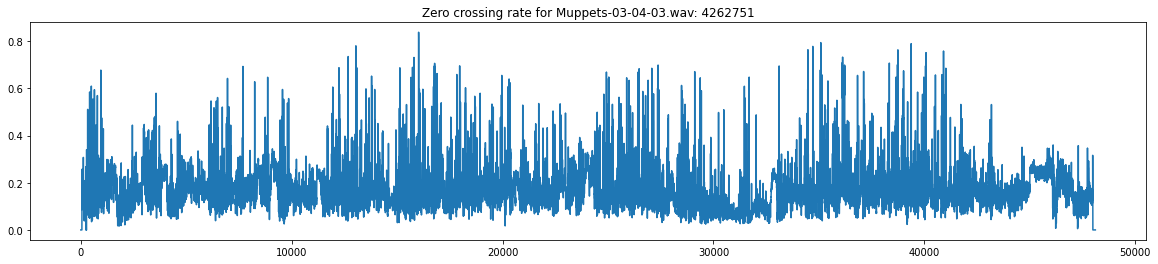

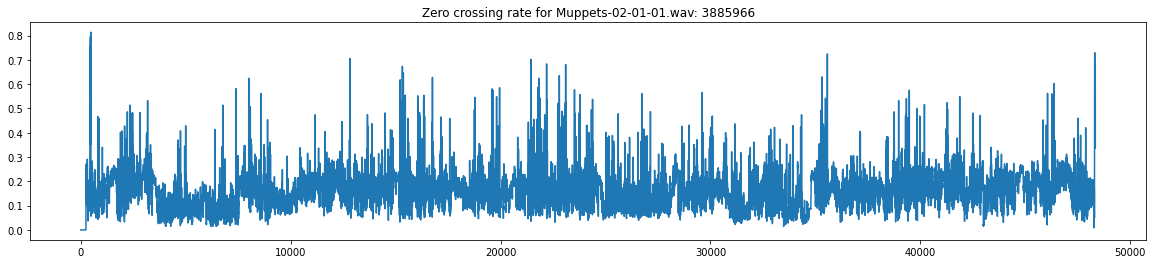

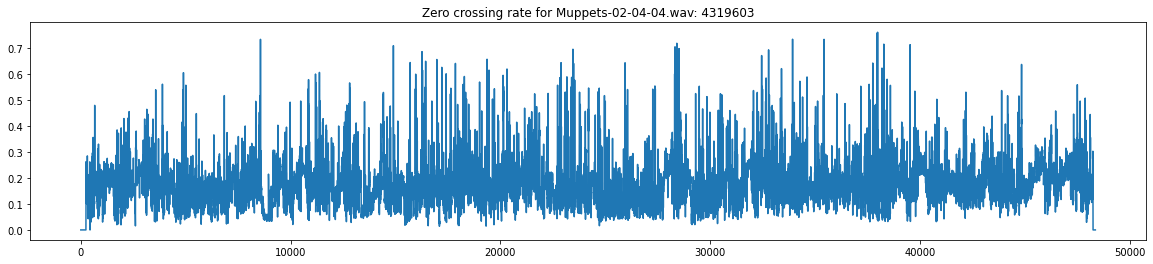

In [18]:
for file_name in df_gt["file_name_audio"].unique():
    zcr = librosa.feature.zero_crossing_rate(signals[file_name])

    plt.figure(figsize=(20, 4))
    plt.plot(zcr[0])
    plt.title(label=f"Zero crossing rate for {file_name}: {sum(librosa.zero_crossings(signals[file_name]))}")

### 1.8.6 Mel spectrograms

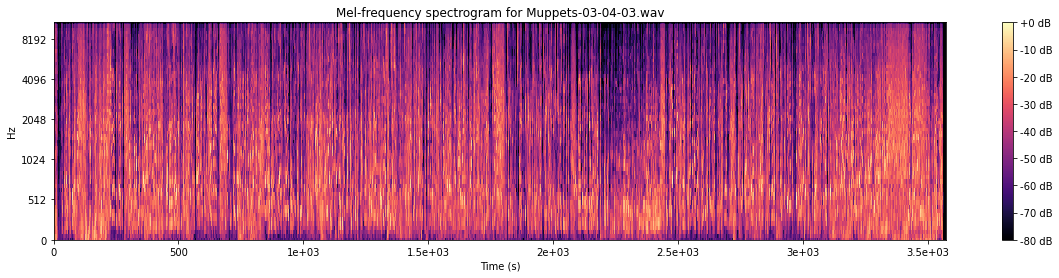

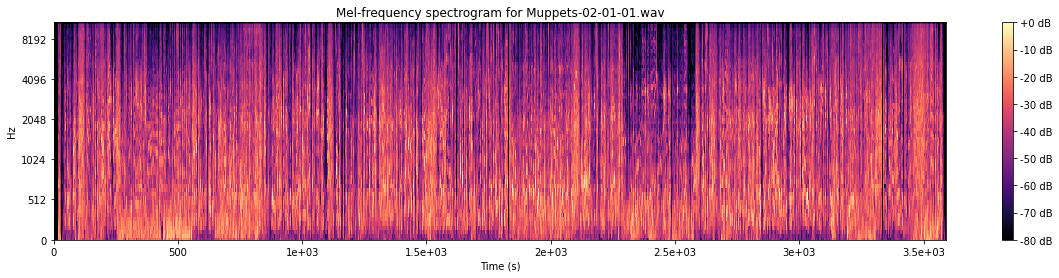

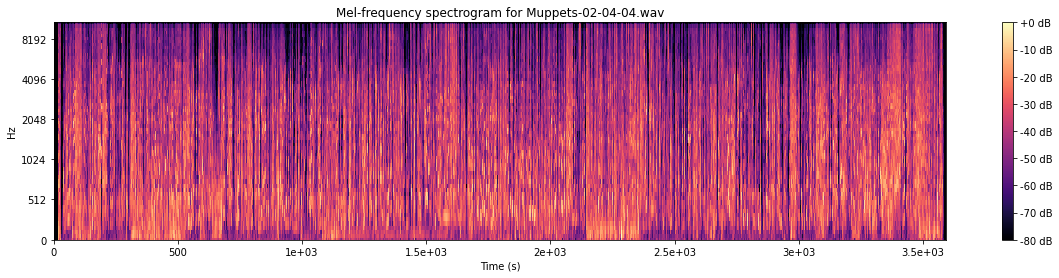

In [19]:
spectrograms = dict()

for file_name in df_gt["file_name_audio"].unique():
    figure, axis = plt.subplots(figsize=(20, 4))

    spectrograms[file_name] = librosa.feature.melspectrogram(y=signals[file_name], sr=sample_rates[file_name], n_fft=N_FFT, hop_length=HOP_LENGTH, n_mels=N_MELS)
    power_to_db = librosa.power_to_db(spectrograms[file_name], ref=np.max)
    
    image = librosa.display.specshow(power_to_db, x_axis="s", y_axis="mel", ax=axis)
    figure.colorbar(image, ax=axis, format="%+2.0f dB")
    axis.set(title=f"Mel-frequency spectrogram for {file_name}")

    plt.show()